# Distal Events Table

__Description__: Excess rainfall is calculated using updated randomized curve numbers and the original precipitation events calculated in `EventsTable.ipynb`. The events are then combined using the groups determined from the convolution steps in `EventsTable.ipynb`.
    
__Input__: 
- Site specific curve number.
- The metadata *.json* file from PM-EventsTable.ipynb, which contains the final precipitation curves for each randomized event.
- The weights *.json* file from PM-EventsTable.ipynb, which contains the weight for each randomized event.


__Output__:
- The incremental excess rainfall for a suite of events at each duration and boundary condition.
- The metadata associated with each event, including the randomized precipitation data, curve numbers, and the underlying events that were grouped to create the final set of events. 
    
---

## A. Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('core')
import hydromet_distal
from hydromet import*

### Parameters:

#### Site specific:

In [2]:
## Excess rainfall parameters:
CN = 85  # Curve number


## Filenames and paths:
AOI = 'Augusta'     # Area of interest
Model = 'P01'  # Model name

root_dir = pl.Path(os.getcwd())
outputs_dir = root_dir/'Outputs'
datarepository_dir = root_dir/'DataRepository'
notebook_dir = root_dir/'Notebooks'


## Options:
display_plots = True
display_print = True
distal = True #Indicate that reEventsTable.ipynb is being executed from this notebook.

#### Global (project specific):

In [3]:
## Filenames and paths:
CN_Distribution = 'NEH630_Table_10_1.json'


## Options:
adjust_CN_less24 = False # Set to True to adjust the curve number when the storm duration is less than 24 hours
remove_intermediates = True
time_idx_ordinate = 'Hours'

start_time = time.time()

###  Data:

#### Metadata:

In [4]:
with open(outputs_dir/'Metadata_{0}_{1}.json'.format(AOI, Model)) as f:
    md = json.load(f)

##### Extract the durations:

In [5]:
durations = list(md.keys())
print('Durations:', durations)

Durations: ['H06', 'H12', 'H24', 'H96']


##### Extract the boundary condition names:

In [6]:
BCN = list(md[durations[0]]['BCName'].keys())
print('Boundary Condition Names:', BCN)

Boundary Condition Names: ['D01']


#### Event weights:

In [7]:
with open(outputs_dir/'Weights_{0}_{1}.json'.format(AOI, Model)) as f:
    weights_dic =  json.load(f)

#### Curve number distribution:

In [8]:
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

{'Dry': 70, 'Wet': 94}


---

## B. Calculate Excess Rainfall and Group Events:
- Extract the data from the metadata dictionary.
- Calculate random curve numbers.
- Perform the excess rainfall calculation.
- Combine the events using the previously determined groups.
- Save the excess rainfall and metadata.
- Plot the results.

Calculating excess rainfall and grouping the 6 hour duration for D01
Calculating excess rainfall and grouping the 12 hour duration for D01
Calculating excess rainfall and grouping the 24 hour duration for D01
Calculating excess rainfall and grouping the 96 hour duration for D01


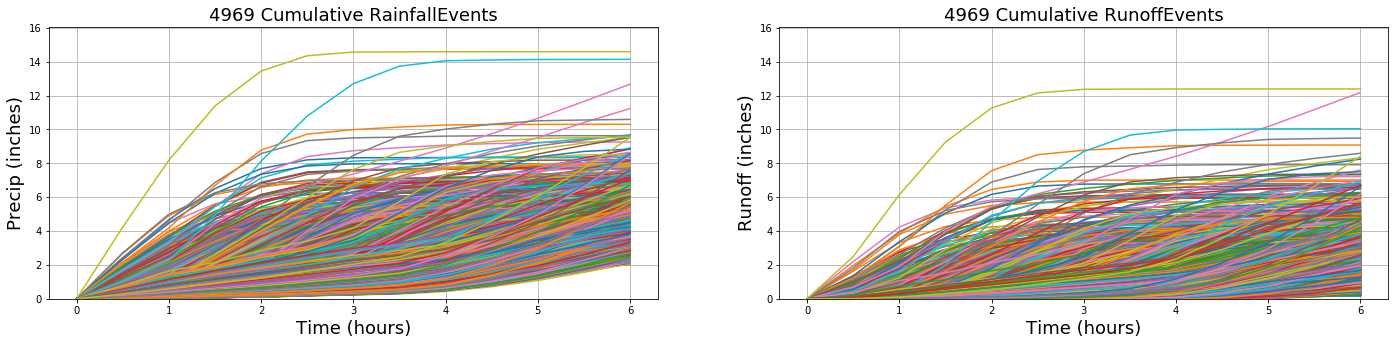

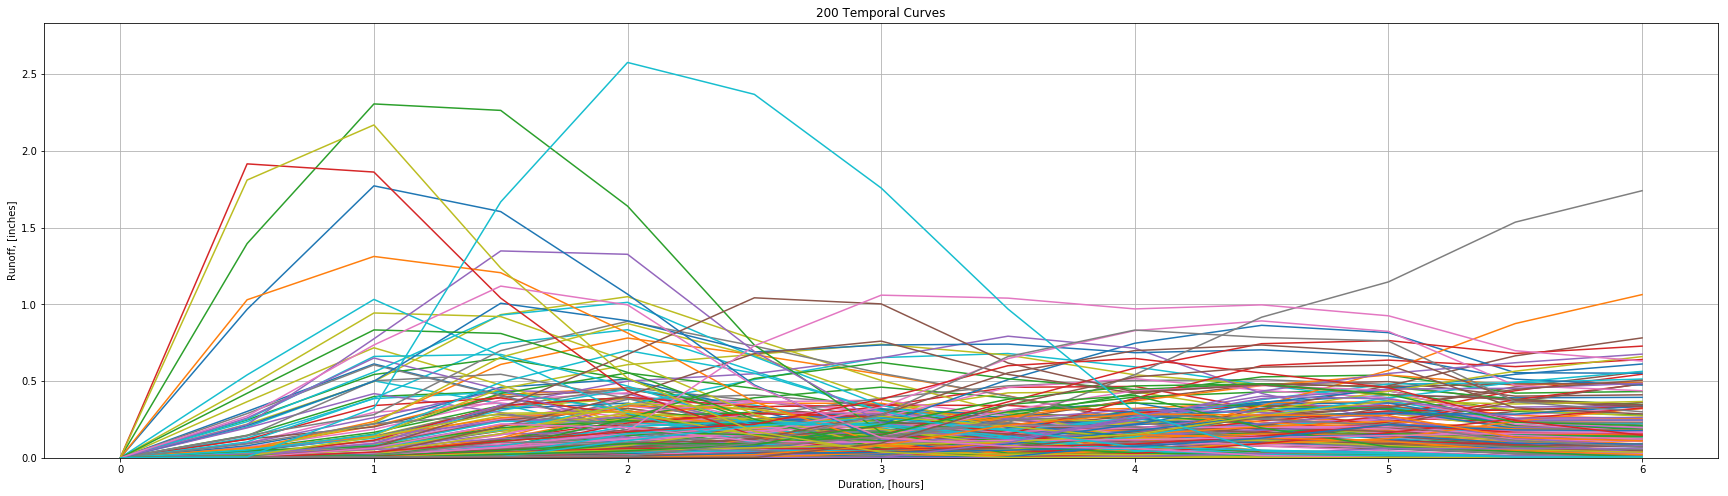

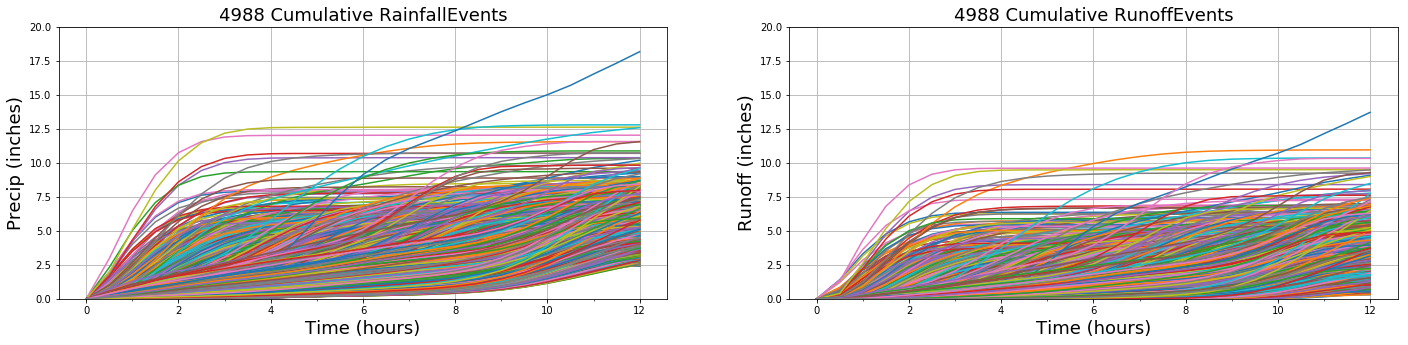

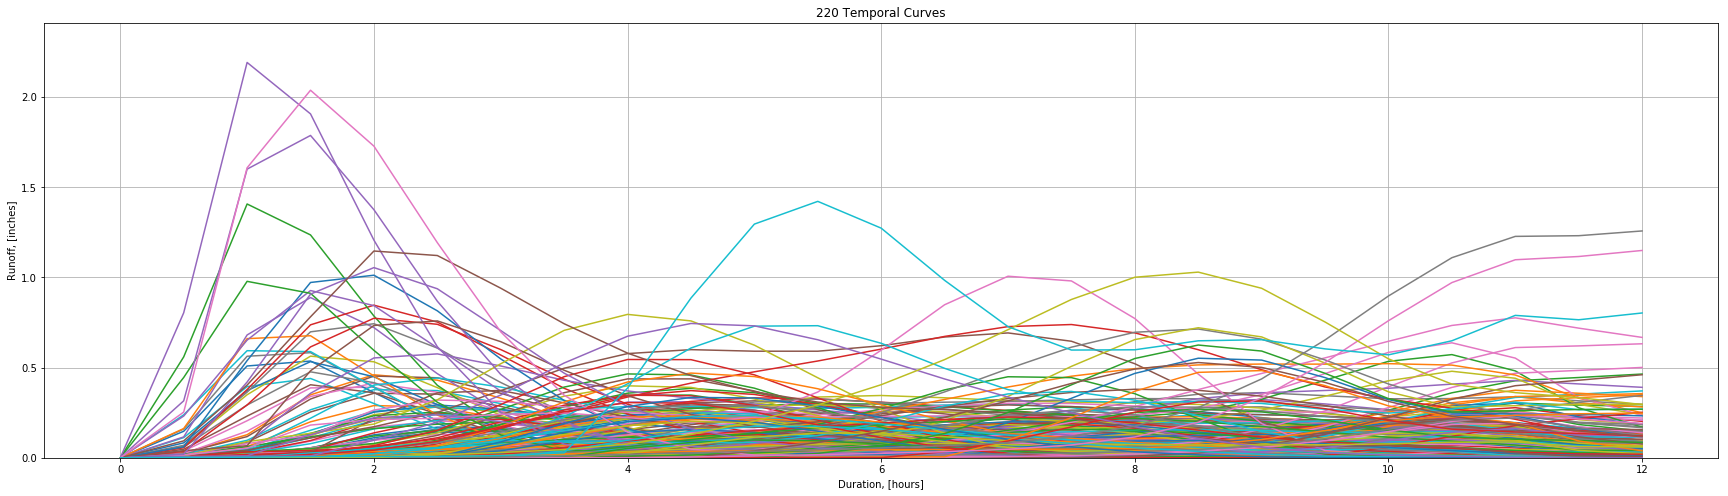

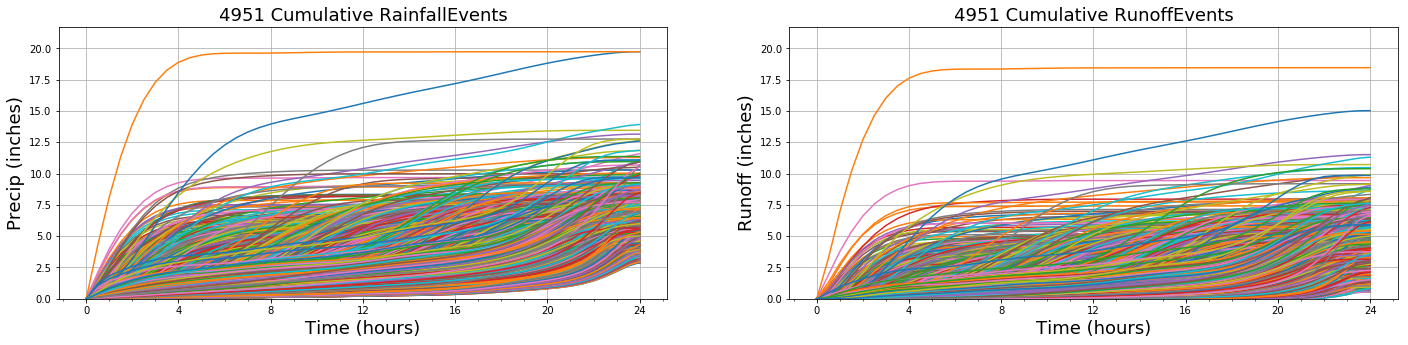

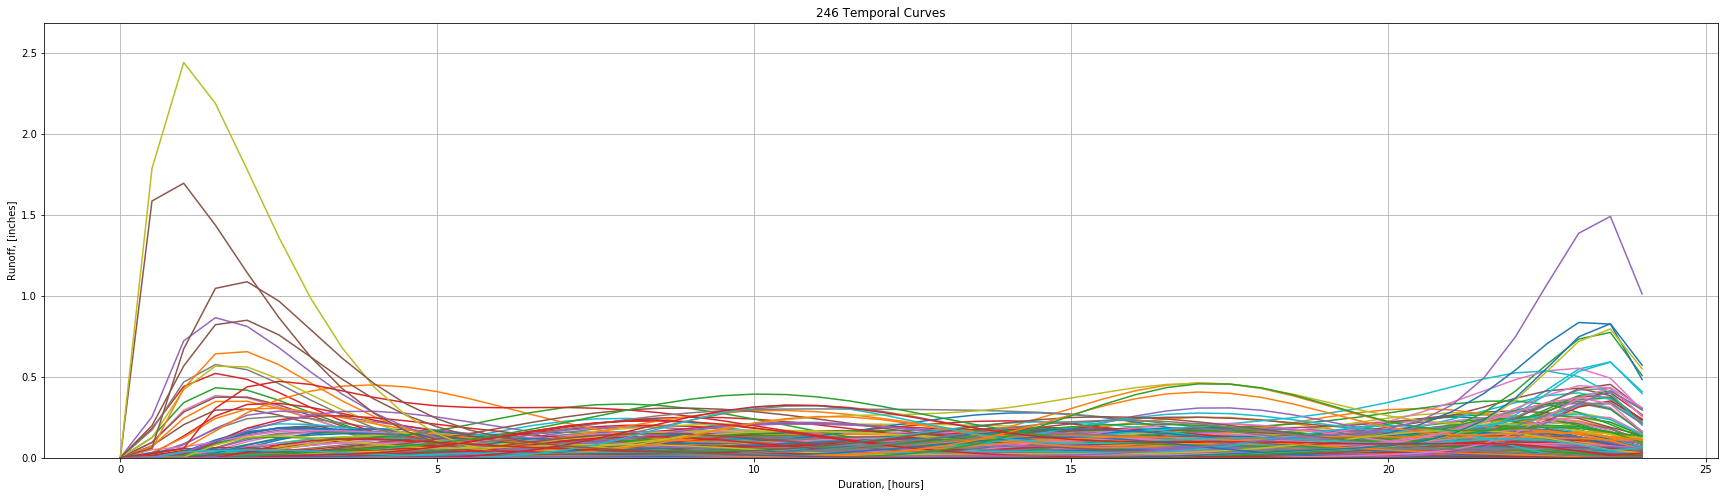

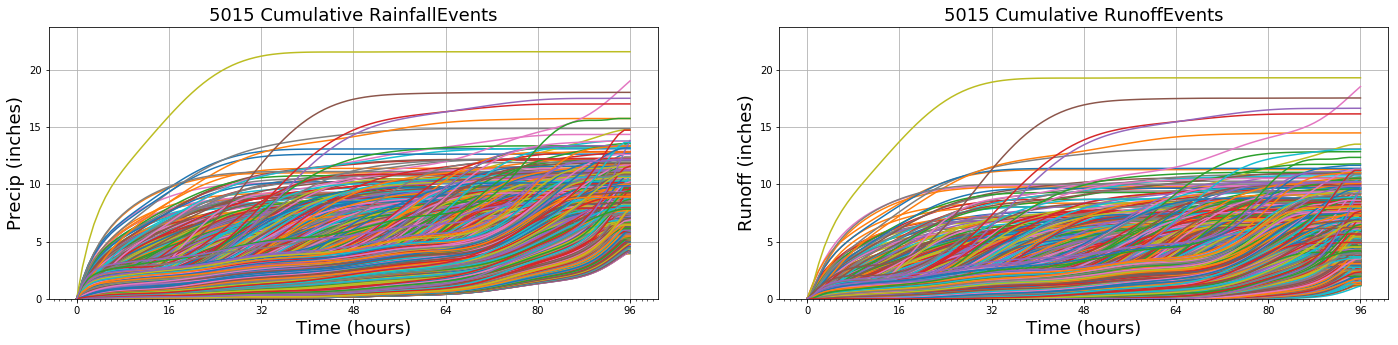

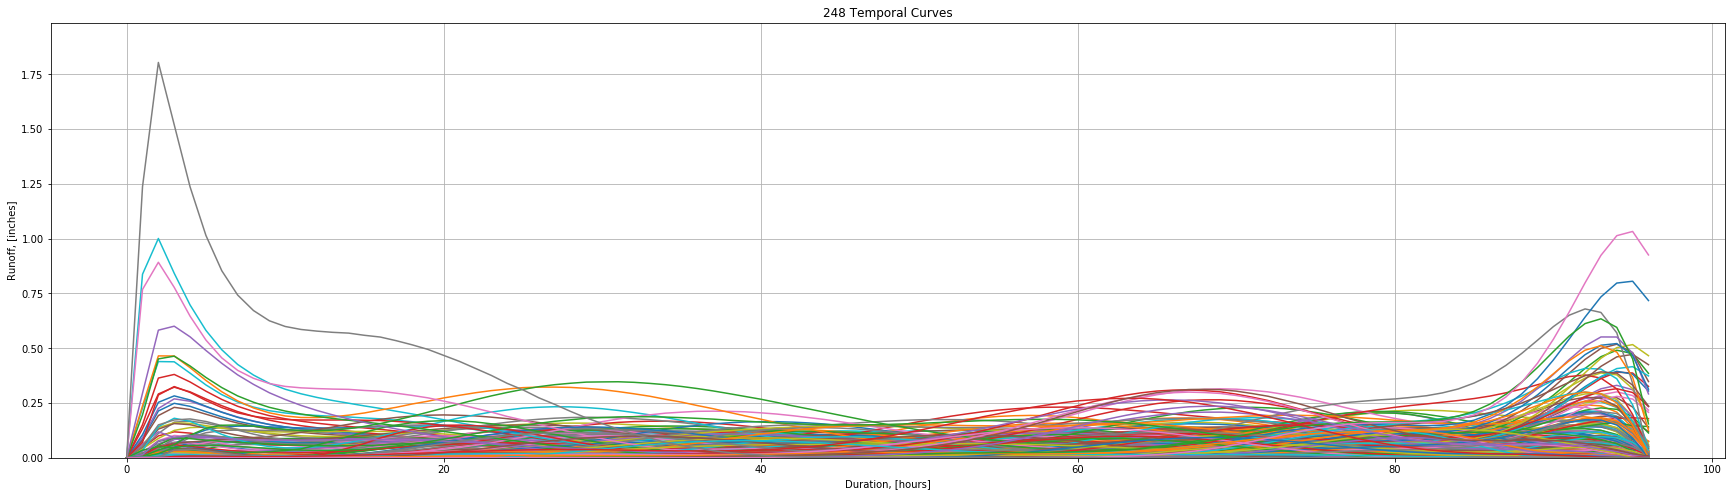

In [9]:
outfiles = []
for dur in durations:
    for name in BCN:
         outfiles.append(hydromet_distal.main(md, dur, name, CN, arc_data, AOI, outputs_dir, adjust_CN_less24, remove_intermediates, display_print, display_plots))

--- 

## C. Combine the All Results and Save:

#### Excess rainfall:

In [10]:
outfiles = extract_list(outfiles)

excess_dic = combine_distal_results(outfiles, 'Excess', BCN, ordin = time_idx_ordinate, remove_ind_dur = remove_intermediates)

with open(outputs_dir/'distal_{0}_{1}.json'.format(AOI, Model), 'w') as f:
    json.dump(excess_dic, f)

#### Metadata:

In [11]:
metadata = combine_distal_results(outfiles, 'Metadata', BCN, ordin = time_idx_ordinate, remove_ind_dur = remove_intermediates)

with open(outputs_dir/'Metadata_distal_{0}_{1}.json'.format(AOI, Model), 'w') as f:
    json.dump(metadata, f)      

### QC the combined results:

#### Plot the weight versus the total runoff for each group

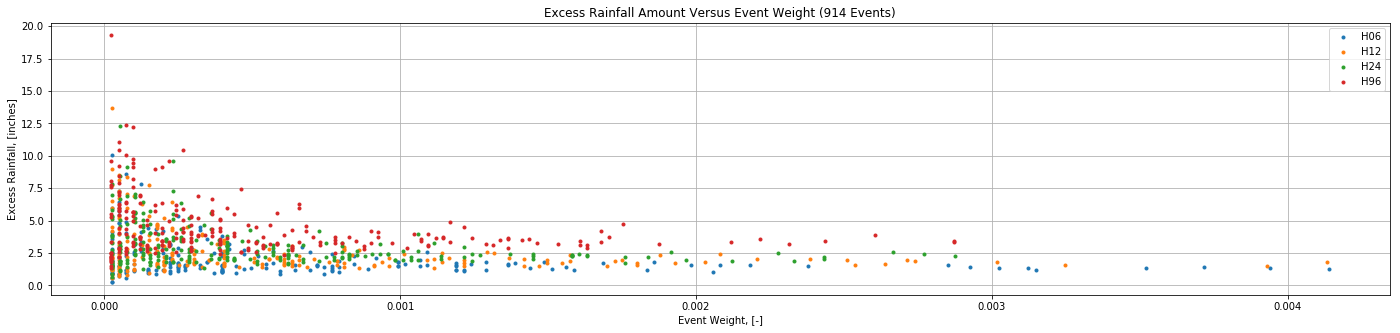

In [12]:
plot_amount_vs_weight(weights_dic, excess_dic, BCN[0])

---

## D. Run ReducedEvents Notebook (Optional):

### Specify:

#### The stormwater removal rate and capacity:

In [13]:
rate = 0.0459    # [L^3/30min]
maxcap = 2.2032  # [L^3]

rand_rate_cap = False # DO NOT MODIFY

#### Or the minimum and maxium stormwater removal rates, which are used to randomly select the removal rate and capacity:

### Run:

In [14]:
reEventsTable = str(notebook_dir/'reEventsTable_distal_{0}_{1}.ipynb'.format(AOI, Model))
                                                                                                                 
if rand_rate_cap:
    nb_parameters = {'minrate': minrate, 'maxrate': maxrate, 'AOI': AOI, 'Model': Model, 'outputs_dir': str(outputs_dir), 
                     'seed': seed, 'rand_rate_cap': rand_rate_cap, 'display_plots': display_plots, 'display_print': display_print, 'distal': distal}
else:
    nb_parameters = {'rate': rate, 'maxcap': maxcap, 'AOI': AOI, 'Model': Model, 'outputs_dir': str(outputs_dir), 
                     'rand_rate_cap': rand_rate_cap, 'display_plots': display_plots, 'display_print': display_print, 'distal': distal}
    
    
pm.execute_notebook('reEventsTable.ipynb', reEventsTable, parameters = nb_parameters);
    
! jupyter nbconvert $reEventsTable --log-level WARN

## E. Save a Copy of this Notebook:

### File save this notebook and then run:

In [15]:
orig_nb = 'distalEventsTable'
new_nb = '{0}_{1}_{2}.ipynb'.format(orig_nb, AOI, Model)
new_nb_path = str(notebook_dir/new_nb)

shutil.copy(root_dir/'{0}.ipynb'.format(orig_nb), new_nb_path)

! jupyter nbconvert $new_nb_path --log-level WARN

if display_print: print('Runtime: {} Minutes'.format(round(time.time()-start_time)/60, 3))         

Runtime: 5.066666666666666 Minutes


---

# End